# Simple environmental sounds training tutorial

---


The objective of this tutorial is to show you the basics of the library and how it can be used to simplify the audio processing pipeline.

This page is generated from the corresponding jupyter notebook, that can be found on [this folder](https://github.com/fastaudio/fastaudio/tree/master/docs)

To install the library, uncomment and run this cell:

In [1]:
#!pip uninstall fastai -y
#!pip install fastai==2.2.7
#!pip install fastaudio
#!pip install fastcore==1.3.19

**Before you continue and import the libs, go to the `Runtime` menu and select `Restart Runtime` and select a GPU runtime.**

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

import IPython

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


## ESC-50: Dataset for Environmental Sound Classification
---

In [17]:
#The first time this will download a dataset that is ~650mb
path = untar_data(URLs.ESC50, dest="ESC50", force_download=True)

The audio files are inside a subfolder `audio/`

In [4]:
(path/"audio").ls()

(#2000) [Path('ESC50/master/audio/5-188495-A-19.wav'),Path('ESC50/master/audio/3-115387-A-47.wav'),Path('ESC50/master/audio/5-160614-B-48.wav'),Path('ESC50/master/audio/2-117330-A-28.wav'),Path('ESC50/master/audio/3-134802-A-13.wav'),Path('ESC50/master/audio/3-126391-A-27.wav'),Path('ESC50/master/audio/5-217186-C-16.wav'),Path('ESC50/master/audio/3-120526-B-37.wav'),Path('ESC50/master/audio/4-126046-A-18.wav'),Path('ESC50/master/audio/1-4211-A-12.wav')...]

And there's another folder `meta/` with some metadata about all the files and the labels

In [5]:
(path/"meta").ls()

(#2) [Path('ESC50/master/meta/esc50-human.xlsx'),Path('ESC50/master/meta/esc50.csv')]

Opening the metadata file

In [6]:
df = pd.read_csv(path/"meta"/"esc50.csv")
df.sample(15)

,filename,fold,target,category,esc10,src_file,take
775,2-89516-A-37.wav,2,37,clock_alarm,False,89516,A
1796,5-212050-A-27.wav,5,27,brushing_teeth,False,212050,A
238,1-50060-A-10.wav,1,10,rain,True,50060,A
124,1-24074-A-43.wav,1,43,car_horn,False,24074,A
559,2-137162-A-11.wav,2,11,sea_waves,True,137162,A
1028,3-154957-A-1.wav,3,1,rooster,True,154957,A
1477,4-191015-A-43.wav,4,43,car_horn,False,191015,A
1783,5-208810-A-11.wav,5,11,sea_waves,True,208810,A
285,1-57163-A-38.wav,1,38,clock_tick,True,57163,A
1462,4-188293-B-15.wav,4,15,water_drops,False,188293,B


In [7]:
IPython.display.Audio("/content/ESC50/master/audio/4-186936-A-44.wav") #engine

In [8]:
IPython.display.Audio("/content/ESC50/master/audio/1-62594-A-32.wav") #typing

## FastAI Datablock and Dataloader preparation

---

* Data processing for PyTorch (or TensorFlow/Keras) would use different libraries and require more "boilerplate" code.  



In [9]:
# Helper function to split the data
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

Creating the Audio to Spectrogram transform from a predefined config.

In [10]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512, n_mels=100)
a2s = AudioToSpec.from_cfg(cfg)

Creating the Datablock

In [11]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref=path/"audio"), 
                 splitter = CrossValidationSplitter(fold=1),
                 item_tfms = [a2s, MaskFreq(num_masks=1), MaskTime(num_masks=2)],
                 get_y = ColReader("category"))

In [12]:
dbunch = auds.dataloaders(df, bs=64) #bs is batch size

Visualizing one batch of data. Notice that the title of each Spectrogram is the corresponding label.

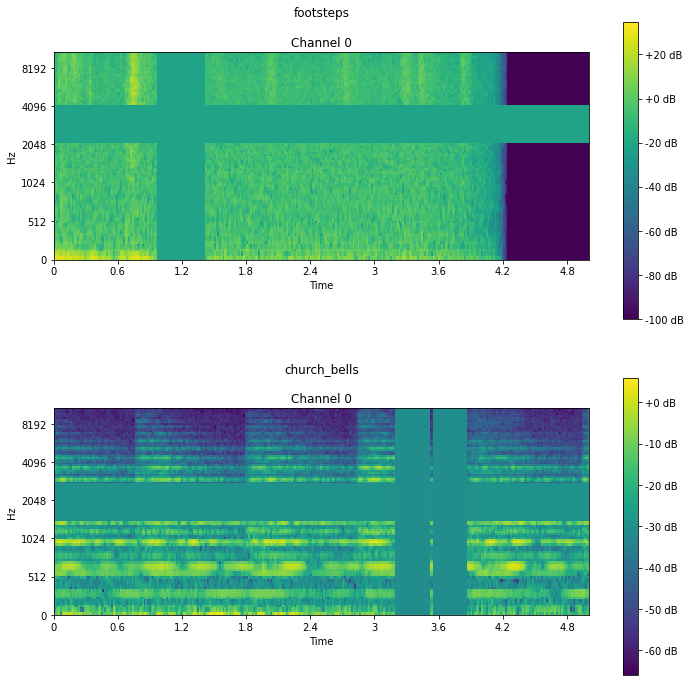

In [13]:
dbunch.show_batch(figsize=(12,12))

In [14]:
auds.summary(df)

Setting-up type transforms pipelines
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]
Found 2000 items
2 datasets of sizes 1600,400
Setting up Pipeline: ColReader -- {'cols': 'filename', '

## Learner and Training
---

While creating the learner, we need to indicate that our input spectrograms only have one channel. Besides that, it's the usual vision learner.

* FastAI will automatically pick up the CUDA GPU engine. 

In [15]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul 22 03:27:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |    911MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# Train on up to five folds:

for fold in range(1,6):
  # Redefine data loader for new fold
  auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref=path/"audio"), 
                 splitter = CrossValidationSplitter(fold=fold),
                 batch_tfms = [a2s],
                 get_y = ColReader("category"))
  dbunch = auds.dataloaders(df, bs=64) 

  # Train model 
  learn = cnn_learner(dbunch, 
            resnet50,
            n_in=1,  # <- this is the only audio specific modification here
            loss_func=CrossEntropyLossFlat(),
            metrics=[accuracy]).to_fp16()
  #print(learn.lr_find()) #learning rate finder
  learn.fit_one_cycle(5, 4e-3)
  learn.unfreeze()
  #print(learn.lr_find()) #learning rate finder
  learn.fit_one_cycle(10, lr_max=slice(2e-6,4e-3))  


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,3.659456,2.095810,0.475000,00:11
1,2.142647,1.621697,0.562500,00:10
2,1.404771,1.329714,0.637500,00:10
3,0.893623,1.159502,0.675000,00:09
4,0.586898,1.098394,0.692500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.155462,1.100760,0.705000,00:11
1,0.182663,1.537498,0.655000,00:10
2,0.351452,1.751974,0.665000,00:11
3,0.347341,1.287288,0.720000,00:11
4,0.247701,1.321958,0.712500,00:10
5,0.158199,1.211381,0.747500,00:11
6,0.101172,1.237689,0.740000,00:11
7,0.067745,1.241782,0.737500,00:10
8,0.043798,1.237403,0.757500,00:10
9,0.029721,1.224564,0.757500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.552365,2.275686,0.445000,00:10
1,2.153237,1.608964,0.572500,00:10
2,1.354161,1.325273,0.637500,00:10
3,0.850801,1.128069,0.687500,00:10
4,0.556277,1.124540,0.712500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.153817,1.210639,0.710000,00:10
1,0.199357,1.786971,0.592500,00:10
2,0.331820,1.626256,0.657500,00:11
3,0.322774,1.336010,0.682500,00:11
4,0.251548,1.138959,0.735000,00:10
5,0.166050,0.969234,0.757500,00:10
6,0.107718,0.937869,0.755000,00:10
7,0.069458,0.895177,0.765000,00:10
8,0.045897,0.884470,0.777500,00:11
9,0.032106,0.890514,0.772500,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.608446,2.011939,0.492500,00:10
1,2.132992,1.590025,0.577500,00:09
2,1.354887,1.310924,0.627500,00:09
3,0.873203,1.116646,0.712500,00:10
4,0.569755,1.109779,0.727500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.172496,1.199608,0.692500,00:11
1,0.192103,1.561927,0.640000,00:10
2,0.333842,1.688131,0.657500,00:10
3,0.354093,1.364690,0.685000,00:10
4,0.276498,1.063986,0.742500,00:10
5,0.197740,1.033190,0.765000,00:10
6,0.132819,0.992297,0.767500,00:11
7,0.084475,0.983077,0.782500,00:10
8,0.055422,0.978366,0.780000,00:10
9,0.036967,0.952606,0.777500,00:11


epoch,train_loss,valid_loss,accuracy,time
0,3.642440,2.147186,0.465000,00:10
1,2.155524,1.526436,0.597500,00:09
2,1.360776,1.116387,0.677500,00:09
3,0.873351,0.977403,0.725000,00:09
4,0.564306,0.953061,0.730000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.141047,0.925737,0.760000,00:11
1,0.191313,1.459186,0.665000,00:11
2,0.333726,1.570950,0.650000,00:10
3,0.335124,1.213426,0.690000,00:10
4,0.259826,1.174489,0.750000,00:10
5,0.177567,0.886614,0.767500,00:10
6,0.113649,0.750559,0.802500,00:11
7,0.074850,0.801678,0.795000,00:11
8,0.050854,0.767757,0.797500,00:10
9,0.035108,0.776409,0.790000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,3.532205,2.103117,0.480000,00:09
1,2.091255,1.853488,0.557500,00:09
2,1.314357,1.403638,0.622500,00:10
3,0.838418,1.294809,0.652500,00:10
4,0.539918,1.247768,0.642500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.155672,1.299266,0.655000,00:10
1,0.218247,1.704065,0.640000,00:10
2,0.317891,1.781661,0.650000,00:10
3,0.340921,1.564759,0.672500,00:11
4,0.251424,1.457075,0.667500,00:11
5,0.171160,1.261586,0.695000,00:10
6,0.119418,1.219453,0.732500,00:11
7,0.078531,1.192743,0.727500,00:11
8,0.050462,1.180498,0.725000,00:10
9,0.033432,1.196953,0.720000,00:10


### ESC-50 SOA accuracy
---

5-fold Cross Val accuracy
* SOA is ~95% in 2021, ~80% in 2018
* Our model with 65 epochs 80.7% 
* Our model with 35 epochs 79.3% 
* Our model with 15 epochs 70.4%


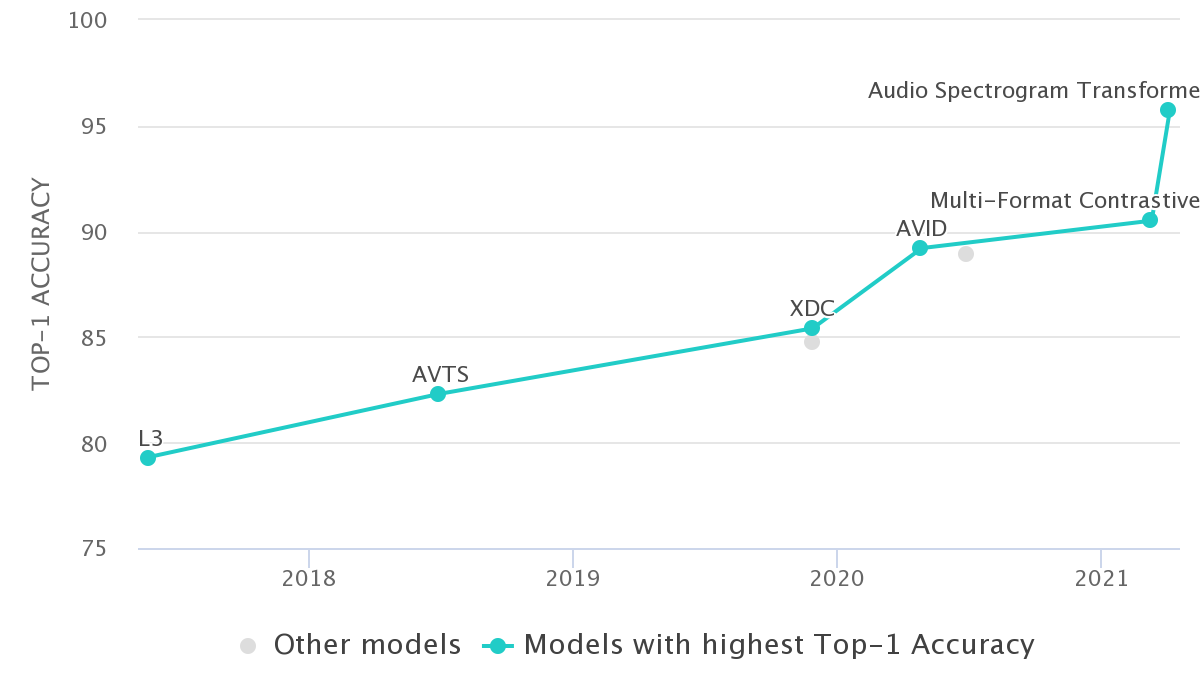